In [16]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.api import tsa
from matplotlib import font_manager as fm, rcParams


plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置
%matplotlib inline

In [2]:
f = pd.read_csv('./user_balance_table.csv', parse_dates=['report_date'])
f[:1000:100]

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
100,1,2014-04-10,20151,20149,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
200,6,2014-08-20,1236,1236,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
300,8,2014-08-19,107947,0,107947,107947,0,107947,0,0,0,0,0,0,NaN,NaN,NaN,NaN
400,11,2014-08-31,1071728,1101956,123,0,0,0,30351,0,30351,0,30351,123,NaN,NaN,NaN,NaN
500,11,2014-05-03,50849,50843,6,0,0,0,0,0,0,0,0,6,NaN,NaN,NaN,NaN
600,23,2014-05-18,1034433,1034301,132,0,0,0,0,0,0,0,0,132,NaN,NaN,NaN,NaN
700,23,2014-03-11,8163583,8180394,305,0,0,0,17116,0,17116,17116,0,305,NaN,NaN,NaN,NaN
800,27,2014-07-02,1999267,1999040,227,0,0,0,0,0,0,0,0,227,NaN,NaN,NaN,NaN
900,27,2014-06-16,1995541,1995291,250,0,0,0,0,0,0,0,0,250,NaN,NaN,NaN,NaN


In [3]:
totaldf = f.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()
totaldf.head()

,total_purchase_amt,total_redeem_amt
report_date,,
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587


Text(0.5, 1.0, '日申购赎回量时序图')

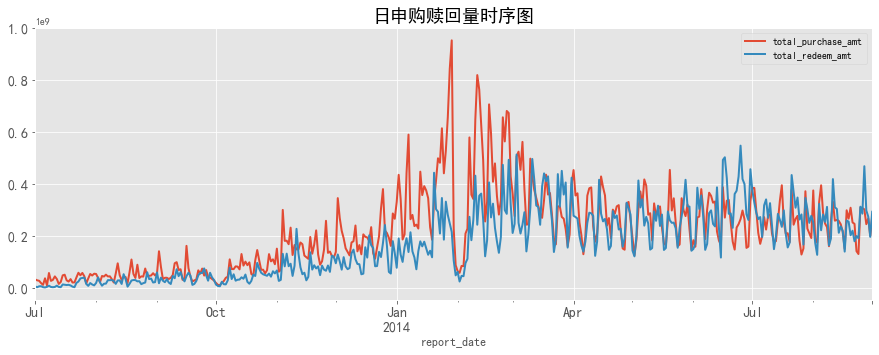

In [4]:
plt.style.use('ggplot')
fig = plt.subplots(figsize=(15,5))
ax1 = plt.subplot2grid((1,1),(0,0))
totaldf.plot(ax=ax1, alpha=2.0, linewidth=2, fontsize=14)
ax1.set_title('日申购赎回量时序图', fontsize=18)

In [6]:
purchase_diff1 = totaldf['total_purchase_amt'].diff(1)
purchase_diff1 = purchase_diff1.fillna(0)

t_purchase = tsa.stattools.adfuller(purchase_diff1)
t_purchase

(-7.956533729495054,
 3.026793703144667e-12,
 18,
 408,
 {'1%': -3.446479704252724,
  '5%': -2.8686500930967354,
  '10%': -2.5705574627547096},
 15956.909450174286)

In [9]:
redeem_diff1 = totaldf['total_redeem_amt'].diff(1)
redeem_diff1 = redeem_diff1.fillna(0)
t_redeem = tsa.stattools.adfuller(redeem_diff1)
t_redeem

(-11.706274612707858,
 1.5262398566198373e-21,
 12,
 414,
 {'1%': -3.4462444670071046,
  '5%': -2.8685466682709975,
  '10%': -2.5705023309762187},
 15816.75911886961)

In [25]:
#划分训练集和验证集
purchase_train = totaldf['total_purchase_amt'][:'2014-07-31']
purchase_val = totaldf['total_purchase_amt']['2014-08-01':]

redeem_train = totaldf['total_redeem_amt'][:'2014-07-31']
redeem_val = totaldf['total_redeem_amt']['2014-08-01':]

purchase_train.tail()


report_date
2014-07-27    151406251
2014-07-28    371762756
2014-07-29    228093046
2014-07-30    209917272
2014-07-31    191728916
Name: total_purchase_amt, dtype: int64

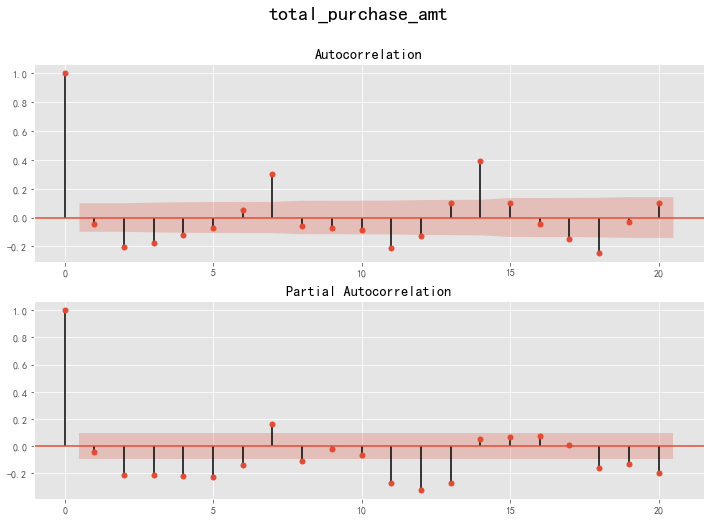

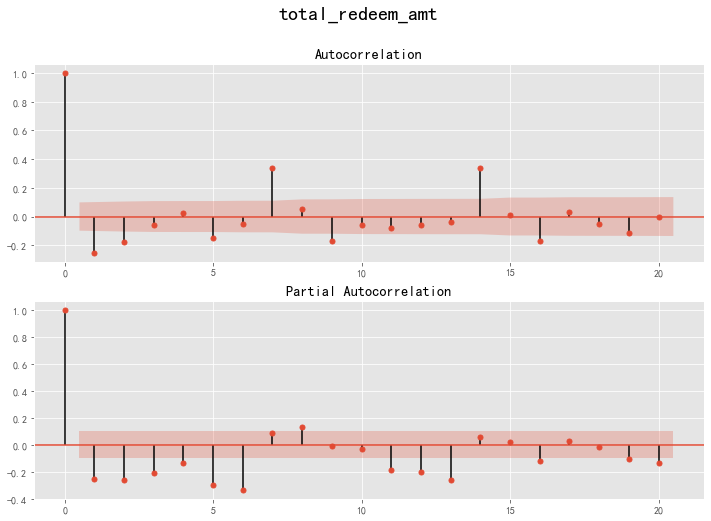

In [27]:
#分析ACF以及PACF 


def autocorrelation(timeseries, lags):
    fig = plt.figure(figsize=(12, 8))
    plt.suptitle(timeseries.name, fontsize=20)
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()
    
purchase_train_diff1 = purchase_train.diff(1).fillna(0)
redeem_train_diff1 = redeem_train.diff(1).fillna(0)
# purchase_train_diff1
autocorrelation(purchase_train_diff1, 20)
autocorrelation(redeem_train_diff1, 20)

In [ ]:
#AIC
#BIC
start = time.time()
purchase_train_evaluate = sm.tsa.arma_order_select_ic(purchase_train_diff1, ic=['aic', 'bic'], trend='nc', max_ar=5, max_ma=5)
print('trend AIC', purchase_train_evaluate.aic_min_order)
print('trend BIC', purchase_train_evaluate.bic_min_order)
end = time.time()
print(end-start)